# Modes of a Ring Resonator

As described in Introduction, another common task for FDTD simulation is to find the resonant modes — frequencies and decay rates — of some cavity structure. You might want to read that again to recall the basic simulation strategy. We will show how this works for a ring resonator, which is simply a waveguide bent into a circle. This script can be also found in examples/ring.py; the notebook is examples/ring.ipynb. In fact, since this structure has cylindrical symmetry, we can simulate it much more efficiently by using cylindrical coordinates, but for illustration here we'll just use an ordinary 2d simulation.

As before, we'll define some parameters to describe the geometry, so that we can easily change the structure:

In [1]:
import meep as mp
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from IPython.display import Video

n = 3.4  # index of waveguide
w = 1  # width of waveguide
r = 1  # inner radius of ring
pad = 4  # padding between waveguide and edge of PML
dpml = 2  # thickness of PML
sxy = 2 * (r + w + pad + dpml)  # cell size

Using MPI version 3.1, 1 processes


How do we make a circular waveguide? So far, we've only seen `Block` objects, but Meep also lets you specify cylinders, spheres, ellipsoids, and cones, as well as user-specified dielectric functions. In this case, we'll use two `Cylinder` objects, one inside the other:

In [2]:
c1 = mp.Cylinder(radius=r + w, material=mp.Medium(index=n))
c2 = mp.Cylinder(radius=r)

Later objects in the `geometry` object take precedence over or rather lie "on top of" earlier objects, so the second `air` ($\epsilon$=1) cylinder cuts a circular hole out of the larger cylinder, leaving a ring of width `w`.

We don't know the frequency of the mode(s) ahead of time, so we'll just hit the structure with a broad Gaussian pulse to excite all of the Ez-polarized modes in a chosen bandwidth:

In [3]:
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse frequency width
src = mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(r + 0.1))

Let's formulate the simulation object and visualize the simulation domain.

-----------
Initializing structure...
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)


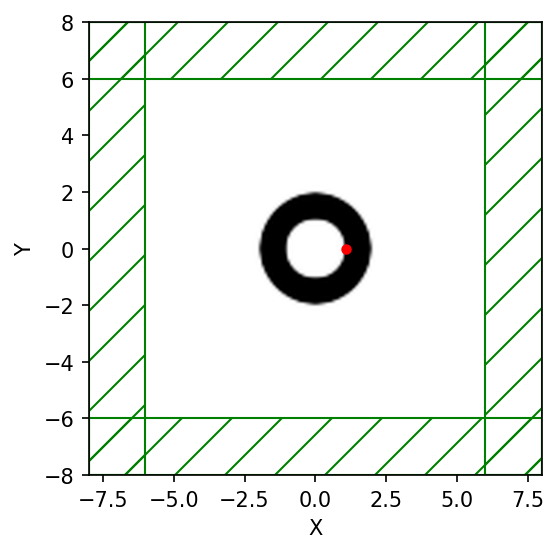

In [4]:
sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    geometry=[c1, c2],
    sources=[src],
    resolution=10,
    boundary_layers=[mp.PML(dpml)],
)
plt.figure(dpi=150)
sim.plot2D()
plt.show()

Finally, we are ready to run the simulation. The basic idea is to run until the sources are finished, and then to run for some additional period of time. In that additional period, we'll perform some signal processing on the fields at some point with Harminv to identify the frequencies and decay rates of the modes that were excited:

In [5]:
sim.run(
    mp.at_beginning(mp.output_epsilon),
    mp.after_sources(mp.Harminv(mp.Ez, mp.Vector3(r + 0.1), fcen, df)),
    until_after_sources=300,
)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.11806892700709783, -0.0007236871181289625, 81.57456727456747, 0.003389451986143974, -0.003074693510136736-0.0014264096834704844i, 6.038103449592875e-06+0.0i
harminv0:, 0.14716744717130087, -0.00020855489877134902, 352.82663710683005, 0.027968648426445402, 0.01873165284311301+0.02076946018959576i, 5.489828592169395e-07+0.0i
harminv0:, 0.1752390711833313, -4.340297760906741e-05, 2018.744805502949, 0.00716056650544672, -0.0008759244837260834-0.007106790342885785i, 1.35846494123861e-06+0.0i
harminv0:, 0.1979976562664712, 0.0010186615368048548, -97.18520289256865, 1.1722788570050586e-05, 4.797901958214431e-06-1.0695976283512917e-05i, 0.0010751369028298237+0.0i
run 0 finished at t = 400.0 (8000 timesteps)


The signal processing is performed by the `Harminv` routine, which takes four arguments: the field component `Ez` and position (`r`+0.1,0) to analyze, and a frequency range given by a center frequency and bandwidth (same as the source pulse). Note that we wrap `Harminv` in after_sources(...), since we only want to analyze the frequencies in the source-free system (the presence of a source will distort the analysis). At the end of the run, `Harminv` prints a series of lines (beginning with `harminv0`:) listing the frequencies it found.

There are six, comma-delimited columns in addition to the label. These results are also stored in `Harminv.modes`. The meaning of these columns is as follows. `Harminv` analyzes the fields $f(t)$ at the given point, and expresses this as a sum of modes in the specified bandwidth:

$$f(t) = \sum_n a_n e^{-i\omega_nt} $$

for complex amplitudes $a_n$ and complex frequencies $\omega_n$. The six columns relate to these quantities. The first column is the _real_ part of $\omega_n$, expressed in our usual $2\pi c$ units, and the second column is the _imaginary part_ — a negative imaginary part corresponds to an exponential decay. This decay rate, for a cavity, is more often expressed as a dimensionless "lifetime" $Q$, defined by:

$$Q=\frac{\mathrm{Re} \omega}{-2\mathrm{Im} \omega} $$

$Q$ is the number of optical periods for the energy to decay by $exp(−2\pi)$, and $1/Q$ is the fractional bandwidth at half-maximum of the resonance peak in Fourier domain. This $Q$ is the third column of the output. The fourth and fifth columns are the absolute value $|a_n|$ and complex amplitudes an. The last column is a crude measure of the error in the frequency (both real and imaginary). If the error is much larger than the imaginary part, for example, then you can't trust the $Q$ to be accurate. Note: this error is only the _uncertainty in the signal processing_, and tells you nothing about the errors from finite resolution, finite cell size, and so on.

An interesting question is how long should we run the simulation, after the sources are turned off, in order to analyze the frequencies. With traditional Fourier analysis, the time would be proportional to the frequency resolution required, but with `Harminv` the time is much shorter. For example, there are three modes. The last has a $Q$ of 1677, which means that the mode decays for about 2000 periods or about 2000/0.175 = 104 time units. We have only analyzed it for about 300 time units, however, and the estimated uncertainty in the frequency is $10^{-7}$ (with an actual error of about $10^{-6}$, from below). In general, you need to increase the run time to get more accuracy, and to find very high $Q$ values, but not by much. In some cases, modes with $Q$ of around 109 can be found with only 200 periods.

In this case, we found three modes in the specified bandwidth, at frequencies of 0.118, 0.147, and 0.175, with corresponding $Q$ values of 81, 316, and 1677. As was shown by Marcatilli in 1969, the $Q$ of a ring resonator increases exponentially with the product of $\omega$ and ring radius. Suppose that we want to actually see the field patterns of these modes. No problem: we just re-run the simulation with a narrow-band source around each mode and output the field at the end.

In particular, to output the field at the end we might add an at_end(`mp.output_efield_z`) argument to our run_after_sources routine, but this is problematic: we might be unlucky and output at a time when the `Ez` field is almost zero (i.e. when all of the energy is in the magnetic field), in which case the picture will be deceptive. Instead, we'll animate the fields.

In [6]:
sim.reset_meep()
fcen = 0.118
df = 0.1
sim.sources = [
    mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(r + 0.1))
]

# Start the simulation and get into steady state
sim.run(until=600)

# Prepare the animator and record the steady state response
f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(0.5, Animate), until=25)

# Close the animator's working frame
plt.close()

# Process the animation and view it
filename = "media/ring_simple.mp4"
Animate.to_mp4(5, filename)
Video(filename)

-----------
Initializing structure...
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
Meep progress: 596.1/600.0 = 99.4% done in 4.0s, 0.0s to go
run 1 finished at t = 600.0 (12000 timesteps)
Normalizing field data...
run 2 finished at t = 625.0 (12500 timesteps)
Generating MP4...


We can also view the results for 0.147

In [7]:
sim.reset_meep()
fcen = 0.147
df = 0.1
sim.sources = [
    mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(r + 0.1))
]
sim.init_sim()

# Start the simulation and get into steady state
sim.run(until=500)

# Prepare the animator and record the steady state response
f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(0.5, Animate), until=25)

# Close the animator's working frame
plt.close()

# Process the animation and view it
filename = "media/ring_mid.mp4"
Animate.to_mp4(5, filename)
Video(filename)

-----------
Initializing structure...
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
run 3 finished at t = 500.0 (10000 timesteps)
Normalizing field data...
run 4 finished at t = 525.0 (10500 timesteps)
Generating MP4...


and for 0.175

In [8]:
sim.reset_meep()
fcen = 0.175
df = 0.1
sim.sources = [
    mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Ez, mp.Vector3(r + 0.1))
]

# Start the simulation and get into steady state
sim.run(until=500)

# Prepare the animator and record the steady state response
f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(0.5, Animate), until=25)

# Close the animator's working frame
plt.close()

# Process the animation and view it
filename = "media/ring_large.mp4"
Animate.to_mp4(5, filename)
Video(filename)

-----------
Initializing structure...
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
run 5 finished at t = 500.0 (10000 timesteps)
Normalizing field data...
run 6 finished at t = 525.0 (10500 timesteps)
Generating MP4...
